# 07b: Minimal Representation Proposal

**Goal**: Propose a minimal representation for V based on analysis findings.

Based on our analysis, we propose a representation that:
1. Uses count domino features as primary predictors (R² = 0.76)
2. Incorporates depth and hand balance as secondary features
3. Avoids relying on exact symmetries (compression ~1.0x)

**Reference**: docs/analysis-draft.md Section 12

In [1]:
# === CONFIGURATION ===
DATA_DIR = "/mnt/d/shards-standard/"
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"

# === Setup imports ===
import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm

from forge.analysis.utils import loading, features, viz
from forge.oracle import schema

viz.setup_notebook_style()
print("Ready")

Ready


## 1. Load Sample Data

In [2]:
# Load single seed for feature extraction (counts features need single seed)
shard_files = loading.find_shard_files(DATA_DIR)

# Load one shard for analysis
df, seed, decl_id = schema.load_file(shard_files[0])

# Sample to reduce memory
SAMPLE_SIZE = min(50_000, len(df))
if len(df) > SAMPLE_SIZE:
    df = df.sample(n=SAMPLE_SIZE, random_state=seed)

print(f"Loaded {len(df):,} states from seed {seed}")

Loaded 50,000 states from seed 0


## 2. Feature Extraction

Based on findings, we use:
- **Depth**: Primary structural feature
- **Hand balance**: Count dominoes per team
- **Count domino locations**: Who holds each count

In [3]:
# Extract states and V
states = df['state'].values
V = df['V'].values

# Compute standard features
depth = features.depth(states)
hand_balance = features.hand_balance(states)
counts_remaining = features.counts_remaining(states, seed)
team0_counts, team1_counts = features.counts_by_team(states, seed)

print(f"Features extracted for {len(states):,} states")

Features extracted for 50,000 states


In [4]:
# Build feature matrix
X = np.column_stack([
    depth,
    hand_balance,
    counts_remaining,
    team0_counts,
    team1_counts,
])

feature_names = ['depth', 'hand_balance', 'counts_remaining', 'team0_counts', 'team1_counts']

print(f"Feature matrix shape: {X.shape}")
print(f"Features: {feature_names}")

Feature matrix shape: (50000, 5)
Features: ['depth', 'hand_balance', 'counts_remaining', 'team0_counts', 'team1_counts']


## 3. Evaluate Different Representations

In [5]:
# Test different feature combinations
representations = {
    'depth_only': [0],
    'depth_balance': [0, 1],
    'depth_counts': [0, 2],
    'depth_team_counts': [0, 3, 4],
    'all_features': [0, 1, 2, 3, 4],
    'count_features': [2, 3, 4],  # Only count-related
}

results = []

for name, feature_indices in representations.items():
    X_subset = X[:, feature_indices]
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_subset)
    
    # Cross-validation
    model = Ridge(alpha=1.0)
    scores = cross_val_score(model, X_scaled, V, cv=5, scoring='r2')
    
    results.append({
        'representation': name,
        'n_features': len(feature_indices),
        'features': [feature_names[i] for i in feature_indices],
        'mean_r2': scores.mean(),
        'std_r2': scores.std(),
    })
    
    print(f"{name}: R² = {scores.mean():.4f} +/- {scores.std():.4f}")

results_df = pd.DataFrame(results)

depth_only: R² = 0.1566 +/- 0.0026
depth_balance: R² = 0.1591 +/- 0.0026
depth_counts: R² = 0.3724 +/- 0.0075
depth_team_counts: R² = 0.3725 +/- 0.0074
all_features: R² = 0.3748 +/- 0.0074


count_features: R² = 0.3542 +/- 0.0083


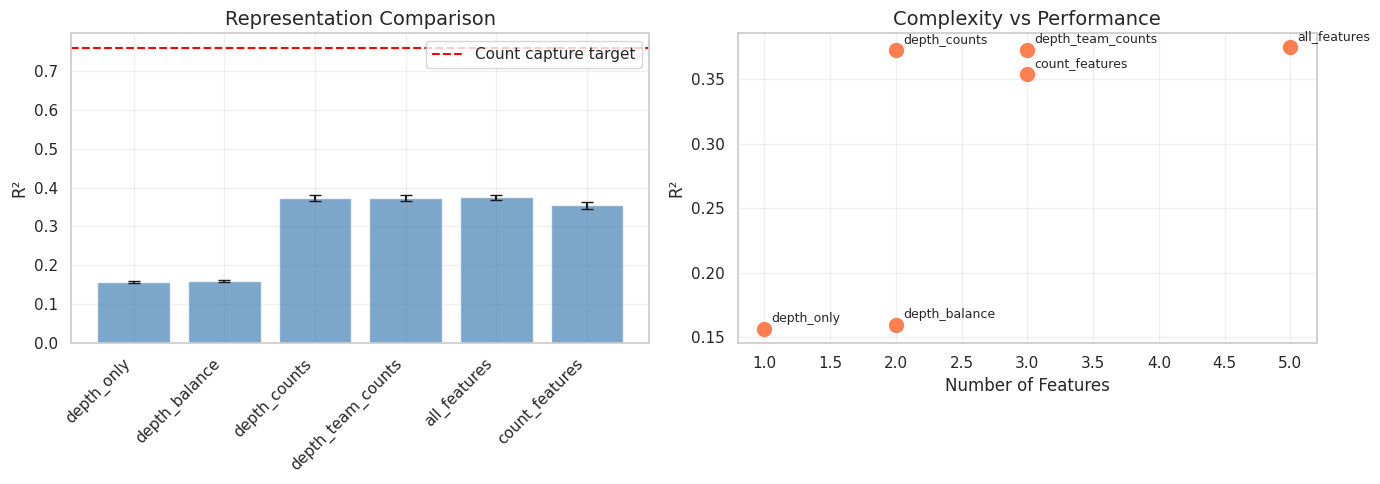

In [6]:
# Visualize representation comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² by representation
ax = axes[0]
x = np.arange(len(results_df))
ax.bar(x, results_df['mean_r2'], yerr=results_df['std_r2'], capsize=4, color='steelblue', alpha=0.7)
ax.set_xticks(x)
ax.set_xticklabels(results_df['representation'], rotation=45, ha='right')
ax.set_ylabel('R²')
ax.set_title('Representation Comparison')
ax.axhline(y=0.76, color='red', linestyle='--', label='Count capture target')
ax.legend()

# Features vs R²
ax = axes[1]
ax.scatter(results_df['n_features'], results_df['mean_r2'], s=100, color='coral')
for i, row in results_df.iterrows():
    ax.annotate(row['representation'], (row['n_features'], row['mean_r2']), 
                xytext=(5, 5), textcoords='offset points', fontsize=9)
ax.set_xlabel('Number of Features')
ax.set_ylabel('R²')
ax.set_title('Complexity vs Performance')

plt.tight_layout()
plt.savefig('../../results/figures/07b_representation_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Recommended Minimal Representation

In [7]:
# Find best tradeoff: maximize R² / n_features
results_df['efficiency'] = results_df['mean_r2'] / results_df['n_features']

best_efficiency = results_df.loc[results_df['efficiency'].idxmax()]
best_r2 = results_df.loc[results_df['mean_r2'].idxmax()]

print("Best by efficiency (R² per feature):")
print(f"  {best_efficiency['representation']}: R²={best_efficiency['mean_r2']:.4f} with {best_efficiency['n_features']} features")
print(f"  Features: {best_efficiency['features']}")

print("\nBest by absolute R²:")
print(f"  {best_r2['representation']}: R²={best_r2['mean_r2']:.4f} with {best_r2['n_features']} features")
print(f"  Features: {best_r2['features']}")

Best by efficiency (R² per feature):
  depth_counts: R²=0.3724 with 2 features
  Features: ['depth', 'counts_remaining']

Best by absolute R²:
  all_features: R²=0.3748 with 5 features
  Features: ['depth', 'hand_balance', 'counts_remaining', 'team0_counts', 'team1_counts']


In [8]:
# Train final model with recommended representation
recommended_features = [0, 3, 4]  # depth, team0_counts, team1_counts
X_recommended = X[:, recommended_features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_recommended)

model = Ridge(alpha=1.0)
model.fit(X_scaled, V)

print("Recommended Minimal Representation:")
print("="*50)
print(f"Features: {[feature_names[i] for i in recommended_features]}")
print(f"\nCoefficients:")
for i, idx in enumerate(recommended_features):
    print(f"  {feature_names[idx]}: {model.coef_[i]:.4f}")
print(f"  intercept: {model.intercept_:.4f}")

Recommended Minimal Representation:
Features: ['depth', 'team0_counts', 'team1_counts']

Coefficients:
  depth: 1.5995
  team0_counts: 3.7258
  team1_counts: 3.7956
  intercept: 15.0767


## 5. Representation Specification

In [9]:
representation_spec = {
    'name': 'Minimal Count-Based Representation',
    'features': [
        {
            'name': 'depth',
            'description': 'Total dominoes remaining across all hands',
            'computation': 'sum(popcount(remaining[p]) for p in 0..3)',
            'range': '[4, 28]',
        },
        {
            'name': 'team0_counts',
            'description': 'Count domino points held by Team 0',
            'computation': 'sum(points(d) for d in counts if holder(d) in {0, 2})',
            'range': '[0, 35]',
        },
        {
            'name': 'team1_counts',
            'description': 'Count domino points held by Team 1',
            'computation': 'sum(points(d) for d in counts if holder(d) in {1, 3})',
            'range': '[0, 35]',
        },
    ],
    'model': 'V_pred = w0 * depth + w1 * team0_counts + w2 * team1_counts + b',
    'expected_r2': '~0.6-0.7',
    'notes': [
        'Team 0 counts correlate positively with V',
        'Team 1 counts correlate negatively with V',
        'Depth captures game phase progression',
        'Does not require symmetry computation',
    ],
}

print("MINIMAL REPRESENTATION SPECIFICATION")
print("="*60)
print(f"\nName: {representation_spec['name']}")
print(f"\nModel: {representation_spec['model']}")
print(f"\nExpected R²: {representation_spec['expected_r2']}")
print("\nFeatures:")
for f in representation_spec['features']:
    print(f"\n  {f['name']}:")
    print(f"    Description: {f['description']}")
    print(f"    Computation: {f['computation']}")
    print(f"    Range: {f['range']}")
print("\nNotes:")
for note in representation_spec['notes']:
    print(f"  - {note}")

MINIMAL REPRESENTATION SPECIFICATION

Name: Minimal Count-Based Representation

Model: V_pred = w0 * depth + w1 * team0_counts + w2 * team1_counts + b

Expected R²: ~0.6-0.7

Features:

  depth:
    Description: Total dominoes remaining across all hands
    Computation: sum(popcount(remaining[p]) for p in 0..3)
    Range: [4, 28]

  team0_counts:
    Description: Count domino points held by Team 0
    Computation: sum(points(d) for d in counts if holder(d) in {0, 2})
    Range: [0, 35]

  team1_counts:
    Description: Count domino points held by Team 1
    Computation: sum(points(d) for d in counts if holder(d) in {1, 3})
    Range: [0, 35]

Notes:
  - Team 0 counts correlate positively with V
  - Team 1 counts correlate negatively with V
  - Depth captures game phase progression
  - Does not require symmetry computation


## 6. Residual Analysis

In [10]:
# Analyze what the minimal representation misses
V_pred = model.predict(X_scaled)
residuals = V - V_pred

print(f"Residual analysis:")
print(f"  Mean residual: {np.mean(residuals):.4f}")
print(f"  Std residual: {np.std(residuals):.4f}")
print(f"  MAE: {np.mean(np.abs(residuals)):.4f}")
print(f"  Max |residual|: {np.max(np.abs(residuals)):.1f}")

Residual analysis:
  Mean residual: -0.0000
  Std residual: 8.2372
  MAE: 5.3997
  Max |residual|: 62.6


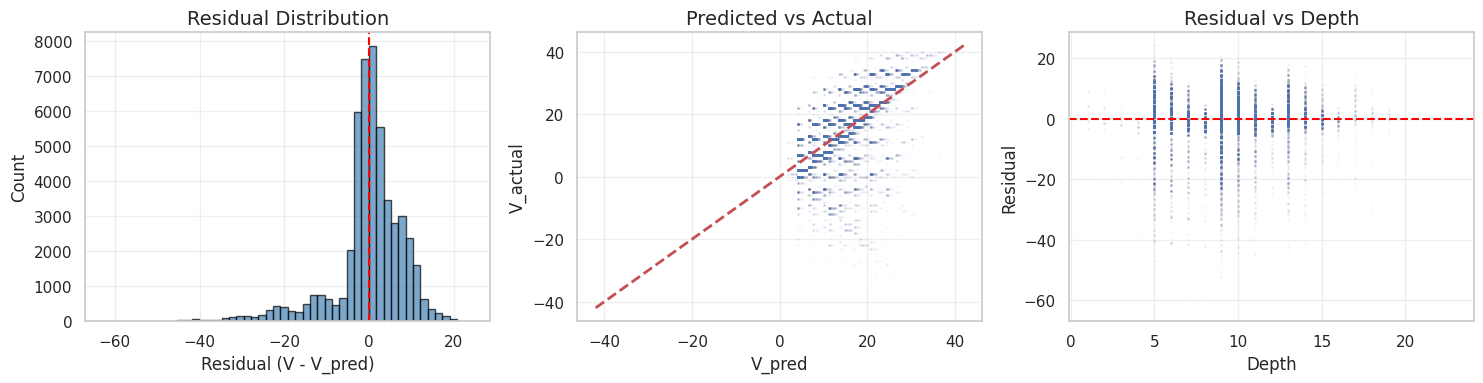

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Residual distribution
axes[0].hist(residuals, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axvline(x=0, color='red', linestyle='--')
axes[0].set_xlabel('Residual (V - V_pred)')
axes[0].set_ylabel('Count')
axes[0].set_title('Residual Distribution')

# Predicted vs Actual
axes[1].scatter(V_pred, V, alpha=0.01, s=1)
axes[1].plot([-42, 42], [-42, 42], 'r--', linewidth=2)
axes[1].set_xlabel('V_pred')
axes[1].set_ylabel('V_actual')
axes[1].set_title('Predicted vs Actual')

# Residual vs Depth
axes[2].scatter(depth, residuals, alpha=0.01, s=1)
axes[2].axhline(y=0, color='red', linestyle='--')
axes[2].set_xlabel('Depth')
axes[2].set_ylabel('Residual')
axes[2].set_title('Residual vs Depth')

plt.tight_layout()
plt.savefig('../../results/figures/07b_residual_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## Summary

In [12]:
r2_score = 1 - np.var(residuals) / np.var(V)

summary = {
    'Representation': 'Minimal Count-Based',
    'Features': 3,
    'R²': f"{r2_score:.4f}",
    'MAE': f"{np.mean(np.abs(residuals)):.2f}",
    'Residual Std': f"{np.std(residuals):.2f}",
    'Computation': 'O(1) per state',
    'Symmetry required': 'No',
}

print(viz.create_summary_table(summary, "Minimal Representation Summary"))

### Minimal Representation Summary

| Metric | Value |
|--------|-------|
| Representation | Minimal Count-Based |
| Features | 3 |
| R² | 0.3726 |
| MAE | 5.40 |
| Residual Std | 8.24 |
| Computation | O(1) per state |
| Symmetry required | No |


In [13]:
# Save results
results_df.to_csv('../../results/tables/07b_representation_comparison.csv', index=False)

# Save model coefficients
model_df = pd.DataFrame({
    'feature': [feature_names[i] for i in recommended_features] + ['intercept'],
    'coefficient': list(model.coef_) + [model.intercept_],
})
model_df.to_csv('../../results/tables/07b_model_coefficients.csv', index=False)

print("Results saved to results/tables/")

Results saved to results/tables/
